That last notebook got messy so I'm making a new cleaner one that will enable me to sample over both emulators simultaneously. 

In [1]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
import numpy as np
import h5py
from chainconsumer import ChainConsumer
#from corner import corner
from ast import literal_eval
from pearce.emulator import LemonPepperWet
from os import path
from scipy.linalg import inv

 /u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.


In [3]:
fname = '/u/ki/swmclau2/des/PearceMCMC/UniverseMachine_wp_ds_rmin_None_HOD.hdf5'

In [4]:
f = h5py.File(fname, 'r')

In [5]:
tf = f.attrs['training_file']
fixed_params = literal_eval(f.attrs['fixed_params'])
if 'rmin' in fixed_params:
    del fixed_params['rmin']
emu_hps = literal_eval(f.attrs['emu_hps'])

In [6]:
tf

array(['/u/ki/swmclau2/des/Aemulators/wp_zheng07_h/PearceWpCosmo.hdf5',
       '/u/ki/swmclau2/des/Aemulators/ds_zheng07_h/PearceDsCosmo.hdf5'],
      dtype='|S61')

In [7]:
fixed_params = fixed_params[0]

In [8]:
emus = []
for t in tf:
    print t
    emus.append(LemonPepperWet(t, fixed_params = fixed_params, hyperparams = emu_hps) )

/u/ki/swmclau2/des/Aemulators/wp_zheng07_h/PearceWpCosmo.hdf5
3
/u/ki/swmclau2/des/Aemulators/ds_zheng07_h/PearceDsCosmo.hdf5
3


In [9]:
chain_pnames = f.attrs['param_names']

In [10]:
n_walkers = f.attrs['nwalkers']

In [11]:
n_burn = 0
chain = f['chain'][n_burn*n_walkers:, :]

In [12]:
rmin = 0#eval(f.attrs['fixed_params'])['rmin']

In [13]:
n_params = chain.shape[1] if len(chain.shape) > 1 else 1

In [14]:
print chain.shape, chain.shape[0]/n_walkers

(779750, 12) 3119


In [15]:
c = ChainConsumer()
chain = chain.reshape((-1, n_walkers, chain.shape[1]))
chain = chain.reshape((-1, chain.shape[2]), order = 'F')
c.add_chain(chain, parameters=list(chain_pnames), walkers = n_walkers)


In [16]:
#MAP = chain.mean(axis = 0)
summary = c.analysis.get_summary(chains=0)
MAP = np.array([summary[key][1] for key in chain_pnames])
print MAP

[ 2.24223074e-02  1.01311582e-01 -7.62721020e-01  9.28063528e-01
  7.47363931e+01  4.27442976e+00  8.42851840e-01  1.37026389e+01
  1.34634315e+01  1.01542962e-01  9.56440091e-01  1.53050898e+00]


In [17]:
chain_pnames

array(['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8', 'logM1',
       'logM0', 'sigma_logM', 'alpha', 'conc_gal_bias'], dtype='|S13')

In [18]:
MAP_dict = dict(zip(chain_pnames, MAP))

In [19]:
#fixed_params = eval(f.attrs['chain_fixed_params'])
#fixed_params.update(eval(f.attrs['sim'])['cosmo_params'])

In [20]:
MAP_dict.update(fixed_params)

In [21]:
MAP_dict

{'H0': 74.73639312087064,
 'Neff': 4.27442976162194,
 'alpha': 0.9564400914367895,
 'conc_gal_bias': 1.5305089792402322,
 'logM0': 13.463431494315525,
 'logM1': 13.702638940948049,
 'ns': 0.9280635279616671,
 'ombh2': 0.022422307384306398,
 'omch2': 0.10131158169947171,
 'sigma8': 0.842851839597847,
 'sigma_logM': 0.10154296202879204,
 'w0': -0.7627210199612928,
 'z': 0.0}

In [22]:
MAP_pred = np.hstack([emu.emulate_wrt_r(MAP_dict, r_bin_centers=emu.scale_bin_centers).squeeze() for emu in emus])
MAP_pred = MAP_pred.reshape((len(emus), -1))

In [23]:
hod_idxs = np.array(range(7, len(chain_pnames)))
cosmo_idxs = np.array(range(7))

In [24]:
if chain.shape[1] == 7:
    cosmo_chain = chain
else:
    hod_chain = chain[:,7:]#[:, hod_idxs]
    cosmo_chain = chain[:,:7]#[:, cosmo_idxs]

In [25]:
from pearce.mocks import cat_dict
cosmo_params = {}

In [26]:
cosmo_params['boxno'] = 1
cosmo_params['realization'] = 1

In [27]:
cat = cat_dict['testbox'](**cosmo_params)#construct the specified catalog!

In [28]:
cpv = cat._get_cosmo_param_names_vals()

cat_val_dict =  {key: val for key, val in zip(cpv[0], cpv[1])}

In [31]:
cat_val_dict

{'H0': 65.7317,
 'Neff': 3.2,
 'ns': 0.971515,
 'ombh2': 0.022762900000000003,
 'omch2': 0.11283,
 'sigma8': 0.7542319000000001,
 'w0': -0.861513}

In [32]:
true_param_dict = cat_val_dict.copy()
hod_params = {'alpha': 1.083, 'conc_gal_bias': 1.0, 'logM0': 13.2,'logM1': 14.2, 'sigma_logM': 0.2}#sim_info['hod_params']
#hod_params = {'alpha': 0.95, 'conc_gal_bias': 1.0, 'logM0': 13.2,'logM1': 14.5, 'sigma_logM': 0.2}#sim_info['hod_params']


#hod_params['mean_occupation_centrals_assembias_param1'] = 0.0
#hod_params['mean_occupation_satellites_assembias_param1'] =0.0
#hod_params['mean_occupation_centrals_assembias_slope1'] = 0.0
#hod_params['mean_occupation_satellites_assembias_slope1'] = 0.0

#for pname in emu.get_param_names():
#    if 'mean_occupation' in pname:
#        hod_params[pname] = 0.0

for hp, hv in hod_params.iteritems():
    if hp == 'logMmin':
        continue
    true_param_dict[hp] = hv

true_param_dict['conc_gal_bias'] = 1.0
true_pred = emu.emulate_wrt_r(true_param_dict)[0]

In [33]:
true_param_dict

{'H0': 65.7317,
 'Neff': 3.2,
 'alpha': 1.083,
 'conc_gal_bias': 1.0,
 'logM0': 13.2,
 'logM1': 14.2,
 'ns': 0.971515,
 'ombh2': 0.022762900000000003,
 'omch2': 0.11283,
 'sigma8': 0.7542319000000001,
 'sigma_logM': 0.2,
 'w0': -0.861513}

In [34]:
true_data = f['data'][()]#.flatten()

In [35]:
true_data = true_data.reshape((2, -1))

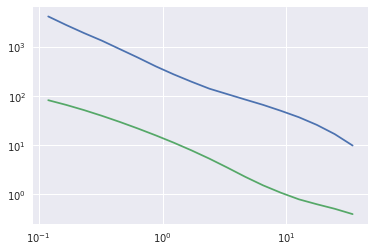

In [36]:
plt.plot(emu.scale_bin_centers, true_data[0])
plt.plot(emu.scale_bin_centers, true_data[1])

plt.loglog();

In [37]:
rbc = emu.scale_bin_centers#[-len(emu.scale_bin_centers):]

In [38]:
cov = f['cov'][()]
yerr = np.sqrt(np.diag(cov)).reshape((len(emus), -1))

In [39]:
true_data[0]

array([4175.84889774, 2796.76726807, 1913.37019631, 1338.06799577,
        900.93561824,  607.5341018 ,  402.66248591,  276.30088782,
        195.3036026 ,  140.83841875,  109.11924002,   84.62075765,
         65.86609395,   49.80634817,   36.88111703,   25.7700211 ,
         16.71764453,    9.78011813])

In [40]:
cov_mean = np.array([7407.57577016, 5860.73332887, 4562.57221101, 3528.4855154 ,
       2653.86635206, 1942.18765577, 1375.70010706,  920.94666884,
        574.1329663 ,  334.4338443 ,  189.53636194,  118.15514169,
         84.2912142 ,   62.74489775,   45.52641089,   31.41342237,
         20.19772416,   11.76164792])

[]

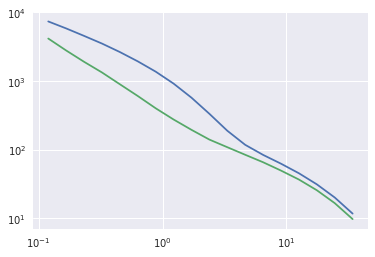

In [41]:
plt.plot(rbc, cov_mean, label = 'Cov Mean')
plt.plot(rbc, true_data[0], label = 'Data')
plt.loglog()

In [42]:
yerr[0]/true_data[0]

array([0.043393  , 0.03572801, 0.02491403, 0.02353166, 0.02712581,
       0.03030204, 0.03064428, 0.02853579, 0.02698483, 0.02607614,
       0.02437616, 0.02401932, 0.02316023, 0.02417529, 0.02721985,
       0.03573569, 0.04950932, 0.08629385])

In [43]:
rbc

array([ 0.11972916,  0.16697228,  0.23285675,  0.32473812,  0.45287435,
        0.63157098,  0.88077831,  1.22831868,  1.71299265,  2.38891085,
        3.33153506,  4.646103  ,  6.47937742,  9.03603121, 12.60149776,
       17.5738377 , 24.50817968, 34.17869685])

In [44]:
def cov_to_corr(cov):
    std = np.sqrt(np.diag(cov))
    
    denom = np.outer(std, std)
    
    return cov/denom

In [45]:
cmap = sns.diverging_palette(240, 10, n=7, as_cmap = True)

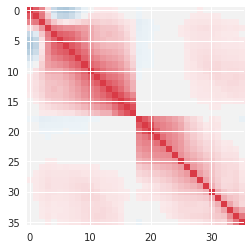

In [46]:
plt.imshow(cov_to_corr(cov ) , cmap=cmap, vmin = -1)

In [47]:
(true_data[1]/(10**emus[1].emulate_wrt_r(true_param_dict).squeeze() ) )

array([1.00314933, 0.98610977, 0.9987164 , 1.01922527, 1.04345263,
       1.07022522, 1.10640489, 1.15857167, 1.22088004, 1.27462303,
       1.27883294, 1.20921513, 1.1119203 , 1.03186001, 0.97479808,
       0.97087642, 0.995704  , 1.02491098])

In [48]:
true_data

array([[4.17584890e+03, 2.79676727e+03, 1.91337020e+03, 1.33806800e+03,
        9.00935618e+02, 6.07534102e+02, 4.02662486e+02, 2.76300888e+02,
        1.95303603e+02, 1.40838419e+02, 1.09119240e+02, 8.46207577e+01,
        6.58660939e+01, 4.98063482e+01, 3.68811170e+01, 2.57700211e+01,
        1.67176445e+01, 9.78011813e+00],
       [8.20626475e+01, 6.58215973e+01, 5.15299728e+01, 3.94055621e+01,
        2.95573292e+01, 2.17734344e+01, 1.57719303e+01, 1.12185065e+01,
        7.79230941e+00, 5.28055637e+00, 3.47557528e+00, 2.25393185e+00,
        1.50906895e+00, 1.06553235e+00, 7.83221868e-01, 6.22334014e-01,
        5.02679278e-01, 3.91403290e-01]])

In [49]:
true_param_dict

{'H0': 65.7317,
 'Neff': 3.2,
 'alpha': 1.083,
 'conc_gal_bias': 1.0,
 'logM0': 13.2,
 'logM1': 14.2,
 'ns': 0.971515,
 'ombh2': 0.022762900000000003,
 'omch2': 0.11283,
 'sigma8': 0.7542319000000001,
 'sigma_logM': 0.2,
 'w0': -0.861513}

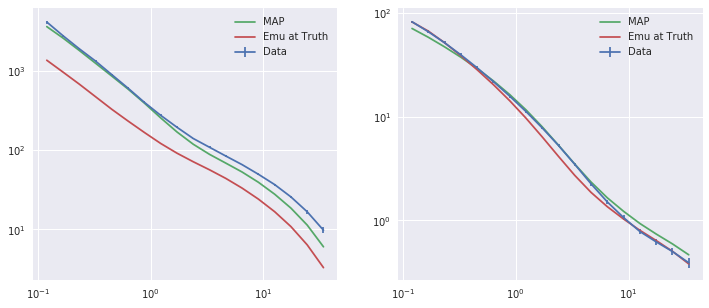

In [50]:
fig = plt.figure(figsize = (12,5))
for i in xrange(len(emus)):
    plt.subplot(1,2,i+1)
    true_pred = emus[i].emulate_wrt_r(true_param_dict).squeeze()
    plt.errorbar(rbc, true_data[i], yerr=yerr[i], label = 'Data')
    plt.plot(rbc, 10**MAP_pred[i], label = 'MAP')
    plt.plot(rbc, 10**true_pred, label = 'Emu at Truth')

    plt.loglog()
    plt.legend(loc='best')
plt.show();

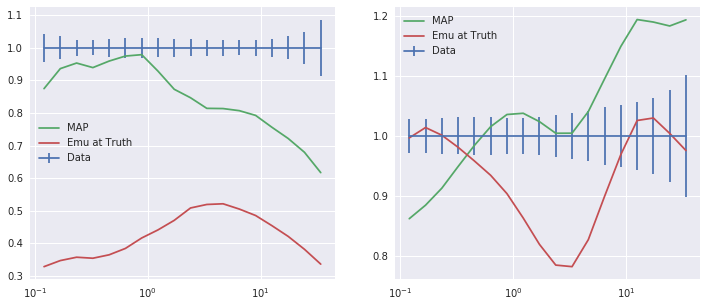

In [51]:
fig = plt.figure(figsize = (12,5))
for i in xrange(len(emus)):
    plt.subplot(1,2,i+1)
    true_pred = emus[i].emulate_wrt_r(true_param_dict).squeeze()
    plt.errorbar(rbc, np.ones_like(true_data[i]), yerr=yerr[i]/true_data[i], label = 'Data')
    plt.plot(rbc, (10**MAP_pred[i])/true_data[i], label = 'MAP')
    plt.plot(rbc, (10**true_pred)/true_data[i], label = 'Emu at Truth')
    plt.legend(loc='best')
    plt.xscale('log')
plt.show();

In [52]:
emu.obs

'ds'

In [53]:
rbc

array([ 0.11972916,  0.16697228,  0.23285675,  0.32473812,  0.45287435,
        0.63157098,  0.88077831,  1.22831868,  1.71299265,  2.38891085,
        3.33153506,  4.646103  ,  6.47937742,  9.03603121, 12.60149776,
       17.5738377 , 24.50817968, 34.17869685])

In [54]:
npart_aemulus = 1400**3
npart_mdpl2 = 3840**3

downsample_factor = 1e-2
npart_aemulus_ds = npart_aemulus*downsample_factor
print npart_aemulus_ds, npart_aemulus_ds/npart_mdpl2

27440000.0 0.000484607837818


In [55]:
chain_pnames

array(['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8', 'logM1',
       'logM0', 'sigma_logM', 'alpha', 'conc_gal_bias'], dtype='|S13')

In [56]:
true_pred = np.hstack([emu.emulate_wrt_r(true_param_dict, r_bin_centers=emu.scale_bin_centers).squeeze() for emu in emus])
true_pred = true_pred.reshape((len(emus), -1))

In [57]:
rmin_idxs = rbc > rmin

In [58]:
cov_rmin_idxs = np.r_[rmin_idxs, rmin_idxs]

In [59]:
print 'True Red. Chi2'
R = (10**true_pred[:, rmin_idxs].flatten()-true_data[:, rmin_idxs].flatten())

chi2 =  R.T.dot(inv(cov[cov_rmin_idxs][:,cov_rmin_idxs])).dot(R)
dof = len(chain_pnames)

print chi2/dof

True Red. Chi2
121.81680602908136


In [60]:
print 'Map Red. Chi2'
R = (10**MAP_pred[:, rmin_idxs].flatten()-true_data[:, rmin_idxs].flatten())

chi2 =  R.T.dot(inv(cov[cov_rmin_idxs][:,cov_rmin_idxs])).dot(R)
dof = len(chain_pnames)

print chi2/dof

Map Red. Chi2
16.37716660697787


In [61]:
N = 10
cmap = sns.color_palette("BrBG_d", N)

In [62]:
emu.get_param_names()

['ombh2',
 'omch2',
 'w0',
 'ns',
 'H0',
 'Neff',
 'sigma8',
 'logM1',
 'logM0',
 'sigma_logM',
 'alpha',
 'conc_gal_bias']

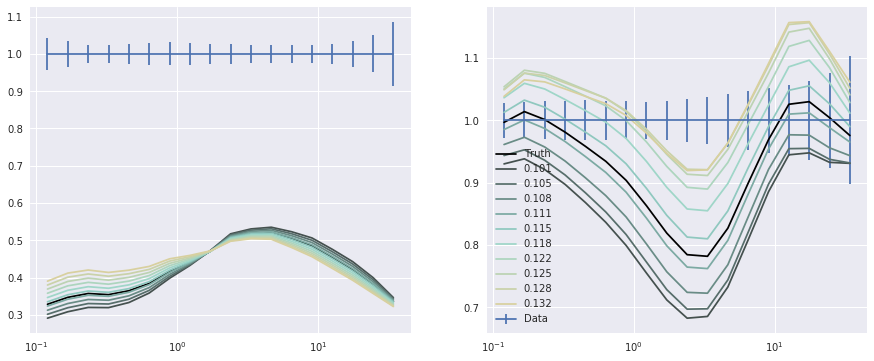

In [63]:
fig = plt.figure(figsize=(15,6))
varied_pname = 'omch2'
lower, upper = emu.get_param_bounds(varied_pname)

for i in xrange(len(emus)):
    plt.subplot(1,2,i+1)
    plt.errorbar(rbc, np.ones_like(true_data[i]), yerr=yerr[i]/true_data[i], label = 'Data')
    pred = emus[i].emulate_wrt_r(true_param_dict).squeeze()
    plt.plot(rbc, (10**pred)/true_data[i], label = 'Truth', color = 'k')    

    plt.xscale('log')
    
for c, val in zip(cmap, np.linspace(lower, upper, N) ):
    param_dict = true_param_dict.copy()
    param_dict[varied_pname] = val

    for i in xrange(len(emus)):
        plt.subplot(1,2,i+1)
        pred = emus[i].emulate_wrt_r(param_dict).squeeze()
        plt.plot(rbc, (10**pred)/true_data[i], label = '%.3f'%val, color = c)
    
plt.legend(loc='best')
plt.show();

In [64]:
emu_avg = 10**(emus[1].y.mean(axis=(0,1))+emu._y_mean)

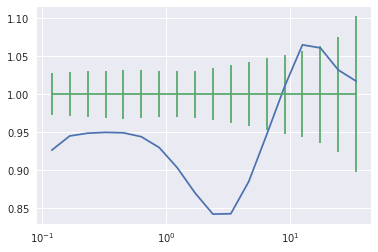

In [65]:
plt.plot(rbc, emu_avg/true_data[1])
plt.errorbar(rbc, np.ones_like(true_data[i]), yerr=yerr[i]/true_data[i])
plt.xscale('log')

In [66]:
cat.load(1.0, HOD='zheng07', particles=True)

most_recent_01_1_particle_2.00


In [67]:
from scipy.optimize import minimize_scalar
def add_logMmin(hod_params, cat, nd = 5e-4):

    hod_params['logMmin'] = 13.0 #initial guess
    #cat.populate(hod_params) #may be overkill, but will ensure params are written everywhere
    def func(logMmin, hod_params):
        hod_params.update({'logMmin':logMmin})
        return (cat.calc_analytic_nd(hod_params, min_ptcl=20) - nd)**2

    res = minimize_scalar(func, bounds = (12,16), args = (hod_params,),\
                          options = {'maxiter':100}, method = 'Bounded')

    # assuming this doens't fail
    print 'logMmin', res.x
    hod_params['logMmin'] = res.x

In [68]:
add_logMmin(hod_params, cat)

logMmin 13.07088948554348


In [69]:
cat.populate(hod_params, min_ptcl = 20)

In [70]:
r_bins = np.logspace(-1, 1.6, 19)

In [71]:
print (r_bins[1:]+r_bins[:-1])/2.0

[ 0.11972916  0.16697228  0.23285675  0.32473812  0.45287435  0.63157098
  0.88077831  1.22831868  1.71299265  2.38891086  3.33153507  4.646103
  6.47937742  9.03603121 12.60149776 17.5738377  24.50817968 34.17869685]


In [72]:
emu.scale_bin_centers

array([ 0.11972916,  0.16697228,  0.23285675,  0.32473812,  0.45287435,
        0.63157098,  0.88077831,  1.22831868,  1.71299265,  2.38891085,
        3.33153506,  4.646103  ,  6.47937742,  9.03603121, 12.60149776,
       17.5738377 , 24.50817968, 34.17869685])

In [73]:
r_bins

array([ 0.1       ,  0.13945832,  0.19448624,  0.27122726,  0.37824899,
        0.52749971,  0.73564225,  1.02591437,  1.43072299,  1.99526231,
        2.7825594 ,  3.88051073,  5.41169527,  7.54705957, 10.52500285,
       14.67799268, 20.46968272, 28.54667663, 39.81071706])

In [74]:
[ 0.1,  0.13945832,  0.19448624,  0.27122726,  0.37824899,
                0.52749971,  0.73564225,  1.02591437,  1.43072299,  1.99526231,
                2.7825594 ,  3.88051073,  5.41169527,  7.54705957, 10.52500285,
                14.67799268, 20.46968272, 28.54667663, 39.81071706]

[0.1,
 0.13945832,
 0.19448624,
 0.27122726,
 0.37824899,
 0.52749971,
 0.73564225,
 1.02591437,
 1.43072299,
 1.99526231,
 2.7825594,
 3.88051073,
 5.41169527,
 7.54705957,
 10.52500285,
 14.67799268,
 20.46968272,
 28.54667663,
 39.81071706]

In [ ]:
wp = cat.calc_wp(r_bins)

In [ ]:
ds = cat.calc_ds(r_bins)

In [ ]:
plt.plot(emu.scale_bin_centers, np.ones_like(true_data[1]), label ='True 1' )
plt.plot(emu.scale_bin_centers, ds/(true_data[1]), label = 'True 2')
plt.plot(emu.scale_bin_centers, (10**emus[1].emulate_wrt_r(true_param_dict).squeeze())/(true_data[1]), label = 'Emu')
plt.legend(loc='best')
plt.xscale('log');